IMDB sentiment analysis dataset.

https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

[1] Maas, A. L., Daly, R. E., Pham, P. T., Huang, D., Ng, A. Y., & Potts, C. (2011, June). Learning Word Vectors for Sentiment Analysis. In Proceedings of the 49th Annual Meeting of the Association for Computational Linguistics: Human Language Technologies (pp. 142-150). [Link](http://www.aclweb.org/anthology/P11-1015)

In [1]:
import pandas as pd

data_file = 'data/IMDB Dataset.csv'
df_raw = pd.read_csv(data_file)
df_raw

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


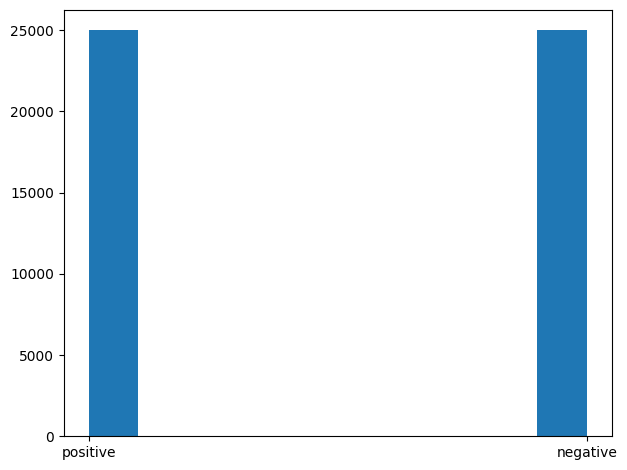

In [2]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.hist(df_raw.sentiment)
fig.tight_layout()

In [3]:
df_formatted = pd.DataFrame()
df_formatted['x'] = df_raw.review
df_formatted['y'] = (df_raw.sentiment == 'positive').astype(int)
df_formatted

,x,y
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1
...,...,...
49995,I thought this movie did a down right good job...,1
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",0
49997,I am a Catholic taught in parochial elementary...,0
49998,I'm going to have to disagree with the previou...,0


In [4]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df_formatted, test_size=0.5, random_state=123, stratify=df_formatted.y)
print(f'Train: {df_train.shape}')
print(f'Test: {df_test.shape}')

Train: (25000, 2)
Test: (25000, 2)


In [5]:
from sklearn.feature_extraction.text import CountVectorizer

cv_params = {
    'ngram_range': (1, 3),
    'token_pattern': r'\w+',
    'max_features': 800000,
}

cv = CountVectorizer(**cv_params)
dtm = cv.fit_transform(df_train.x)
dtm

<25000x800000 sparse matrix of type '<class 'numpy.int64'>'
	with 10619416 stored elements in Compressed Sparse Row format>

In [6]:
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()
nb.fit(dtm, df_train.y)
print(f'Classes: {nb.classes_}')
print(f'Log probs shape: {nb.feature_log_prob_.shape}')
print(f'Log probs: {nb.feature_log_prob_}')

Classes: [0 1]
Log probs shape: (2, 800000)
Log probs: [[-10.55601814 -14.74060958 -14.74060958 ... -14.74060958 -15.83922187
  -14.22978396]
 [-12.06037849 -15.15142095 -15.15142095 ... -14.45827377 -14.05280866
  -14.45827377]]


In [7]:
log_probs = nb.feature_log_prob_[0] - nb.feature_log_prob_[1]
log_probs.shape

(800000,)

In [8]:
from itertools import islice

vocab = cv.vocabulary_
print(f'Vocab lenght: {len(vocab)}')
print(f'Vocab slice: {dict(islice(vocab.items(), 5))}')

Vocab lenght: 800000
Vocab slice: {'this': 727512, 'picture': 525671, 'hit': 286679, 'the': 670083, 'movie': 431200}


In [9]:
binary_cv = CountVectorizer(binary=True, vocabulary=vocab, **cv_params)
binary_dtm_train = binary_cv.fit_transform(df_train.x)
binary_dtm_test = binary_cv.transform(df_test.x)
probs_train = binary_dtm_train.multiply(log_probs)
probs_test = binary_dtm_test.multiply(log_probs)
print(f'Train probs shape: {probs_train.shape}')
print(f'Test probs shape: {probs_test.shape}')

Train probs shape: (25000, 800000)
Test probs shape: (25000, 800000)


In [10]:
from sklearn.preprocessing import MaxAbsScaler

scaler = MaxAbsScaler()
scaled_probs_train = scaler.fit_transform(probs_train)
scaled_probs_test = scaler.transform(probs_test)

In [11]:
from sklearn.svm import LinearSVC

svm = LinearSVC(max_iter=10000)
svm.fit(scaled_probs_train, df_train.y)
svm_score = svm.score(scaled_probs_test, df_test.y)
print(f'SVM score: {svm_score}')

SVM score: 0.90304


In [12]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(solver='saga', max_iter=10000)
lr.fit(scaled_probs_train, df_train.y)
lr_score = lr.score(scaled_probs_test, df_test.y)
print(f'LR score: {lr_score}')

LR score: 0.9078
